# Entanglement forged expectation value


## Motivation

We propose a simple and generic interface for expectation values and their gradients.
The current workflow with opflow to get an expectation value is as follows.
```python
state = StateFn(...) # can be a circuit-based state or defined via a statevector or dictionary
operator = ... # some opflow operator, e.g. PauliSumOp
expectation = StateFn(operator, is_measurement=True) @ state
expectation_converter = PauliExpectation # method to evaluate the expected value, e.g. PauliExpectation, CVaRExpectation, AerPauliExpectation, ...
circuit_sampler = CircuitSampler(backend)
converted = expectation_converter.convert(expectation) 
sampled = circuit_sampler.convert(converted, parameters)
result = sampled.eval()
```

We propose a new design of the expectation value to make it generic and simple.
Essentially, we aim at the following workflow.

```python
operator = ... # some opflow operator, e.g. PauliSumOp
state = ... # a parametrized quantum circuit (or ansatz)
backend = ... # AerBackend or IBMQBackend
expval = PauliExpectationValue(state, operator, backend)
result = expval.evaluate(parameters).value
```

## Outline of the new design

We propose an abstract class for expectation value and gradient.
An instance will be initialized with the following objects:

- `state` $\psi(\theta)$: a (parametrized) quantum circuit or a state vector to be converted into a quantum circuit.
- `observable` $H$: we allow opflow `PauliSumOp` (primitive is `SparsePauliOp`) or quantum_info operator `BaseOperator` that is compatible with `SparsePauliOp` for simplicity.
- `backend`: Either `IBMQBackend` or `AerSimulator`. We don't support legacy simulator backends and BasicAer.
- (optional) `expval`: take an expectation value object as an input (e.g., gradient)

Users use `ExpectationValue.evaluate(parameters)` to obtain the expectation value.

Instances of our expectation value classes are immutable.
Users need to invoke the constructor to evaluate the expectation value of different states or observables.

The internal workflow consists of phases:

1. `ExpectationValue._preprocessing` generates quantum circuits corresponding to the pair of quantum state and observable. The circuits maybe left parametrized. This will be invoked on demand to avoid overhead of the constructor.
2. `ExpectationValue.evaluate(parameters)` transpiles quantum circuits (if necessary), puts parameter values to the transpiled circuits, and executes them on the backend.
3. `ExpectationValue._postprocessing` interprets the results of the backend into an expectation value and other information as `ExpectationValueResult`.

## Entanglement forging

References:
- "Doubling the size of quantum simulators by entanglement forging" https://arxiv.org/abs/2104.10220
- Qiskit seminar series: [Doubling the Size of Quantum Simulators by Entanglement Forging](https://www.youtube.com/watch?v=vJZRUf1abQs) 


### Motivation

- Who to apply wealth of classical computing resources to extend the reach of small noisy quantum processors
- Decompose large circuits into distribution of smaller ones

### Theory

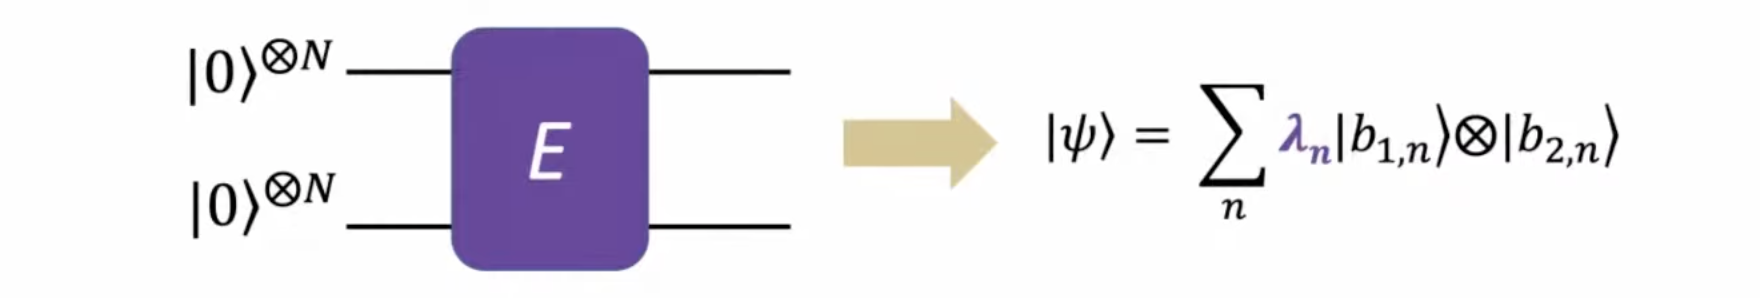
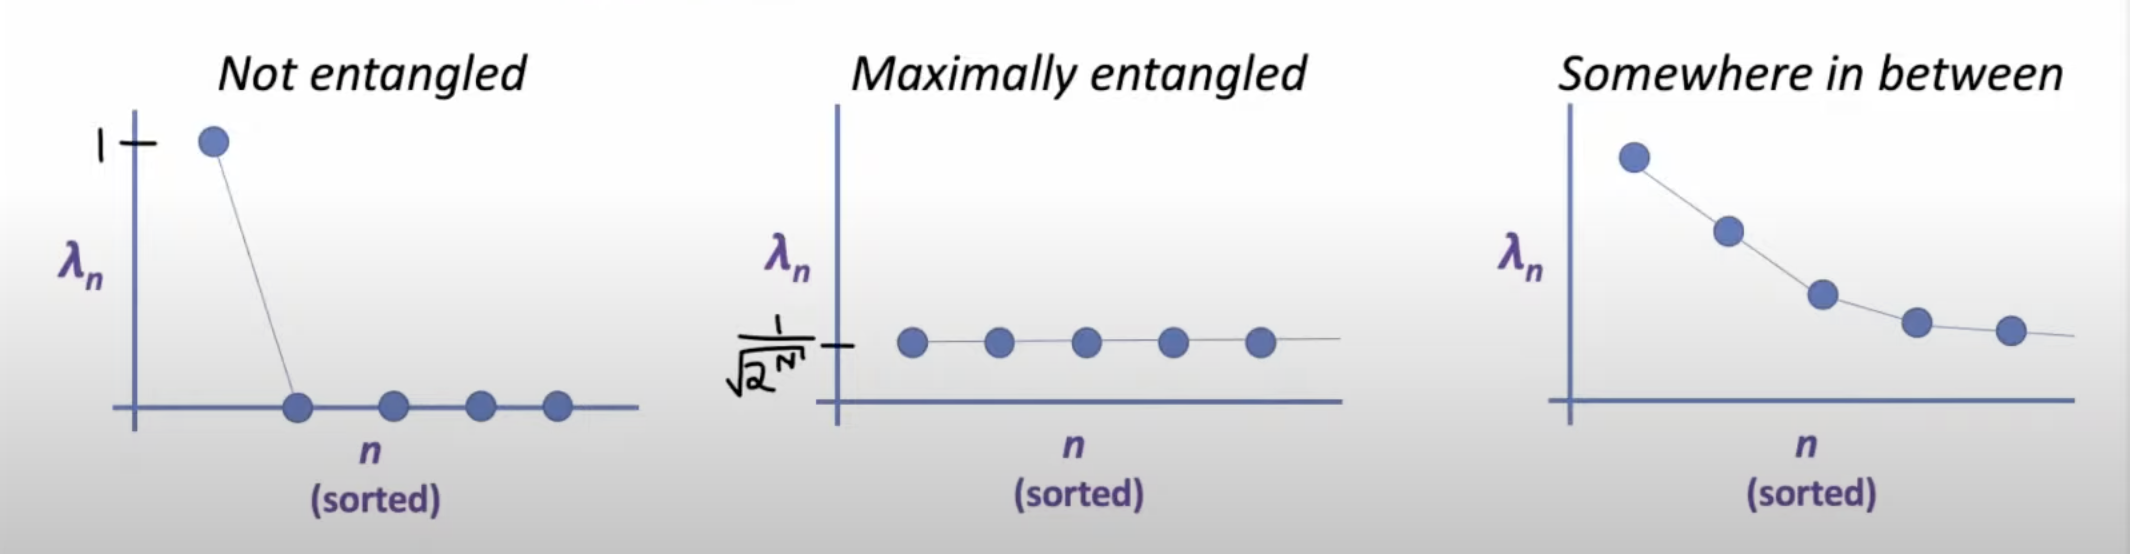
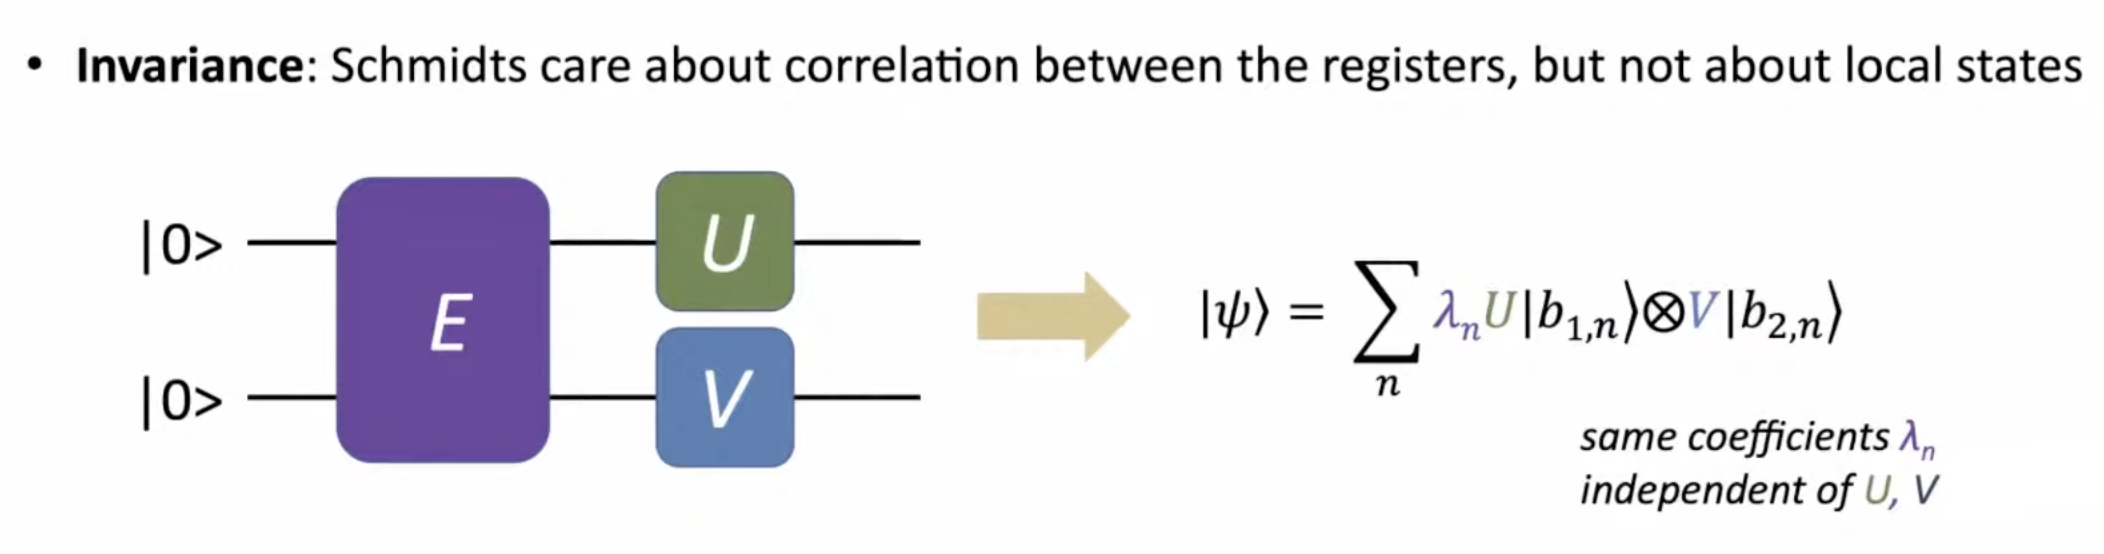
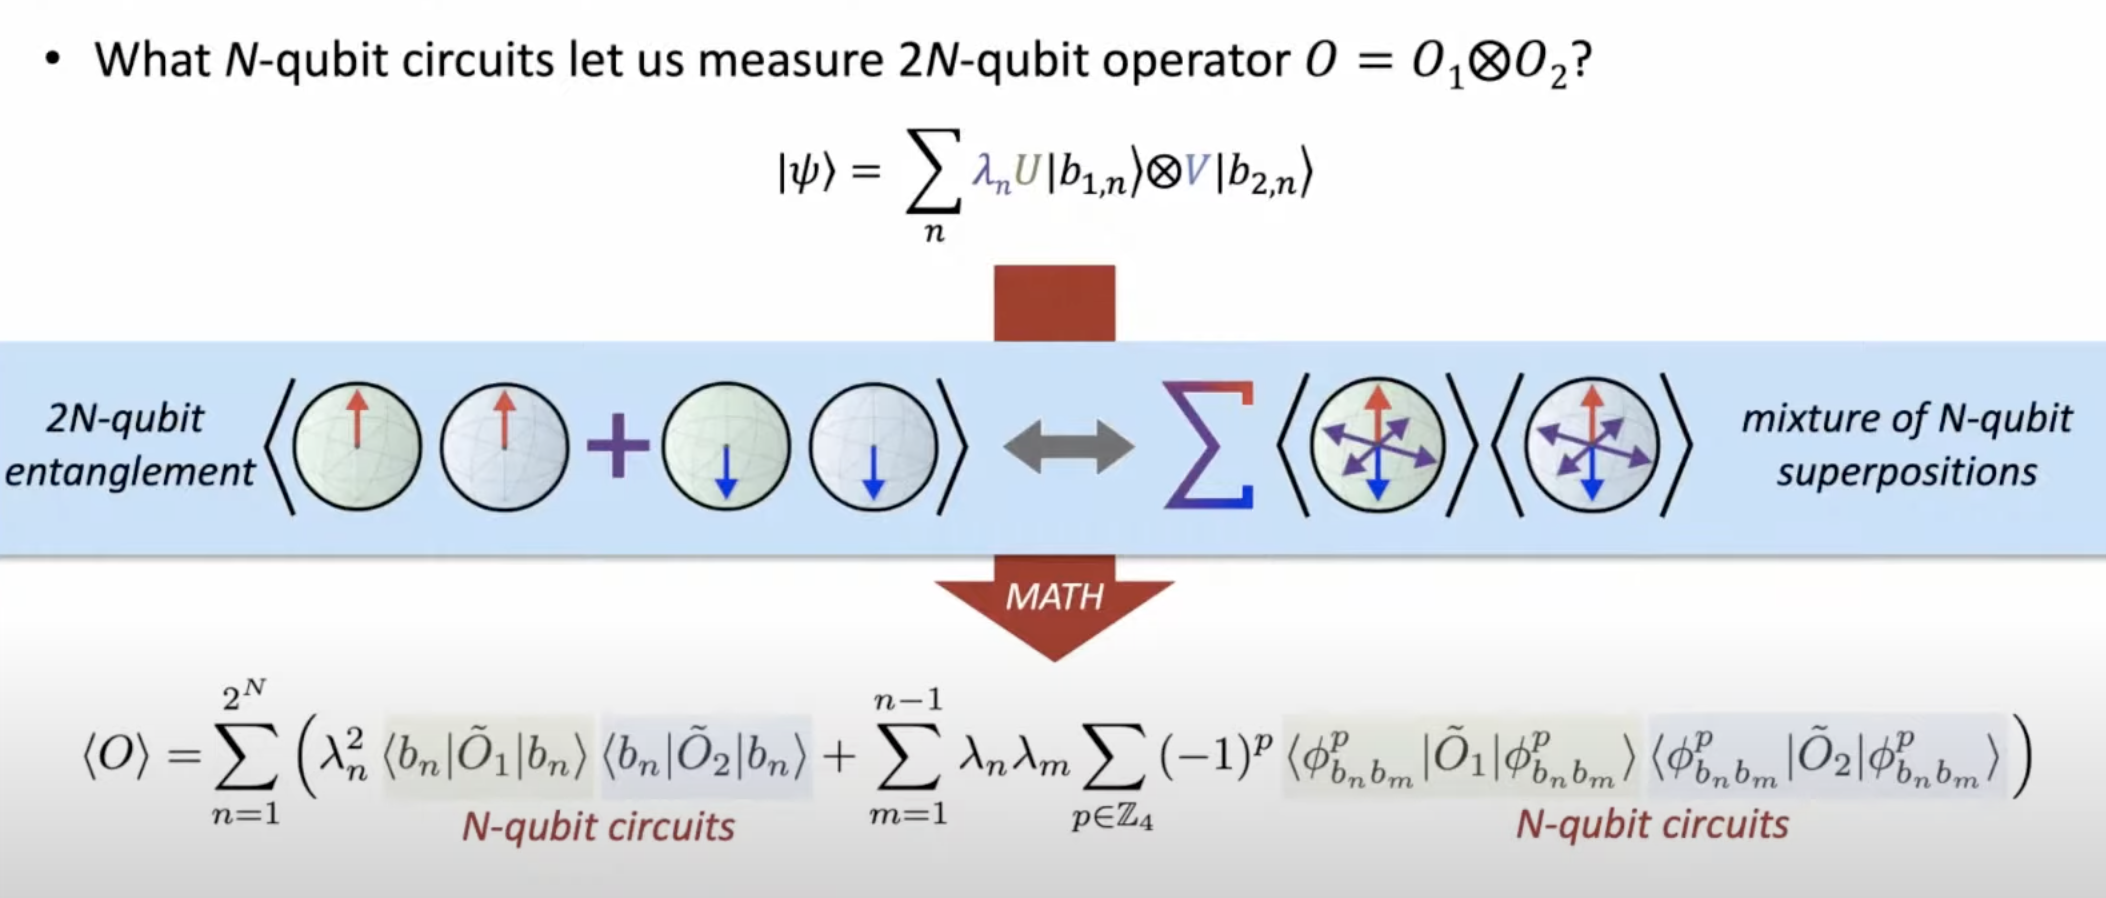

Circuits to run
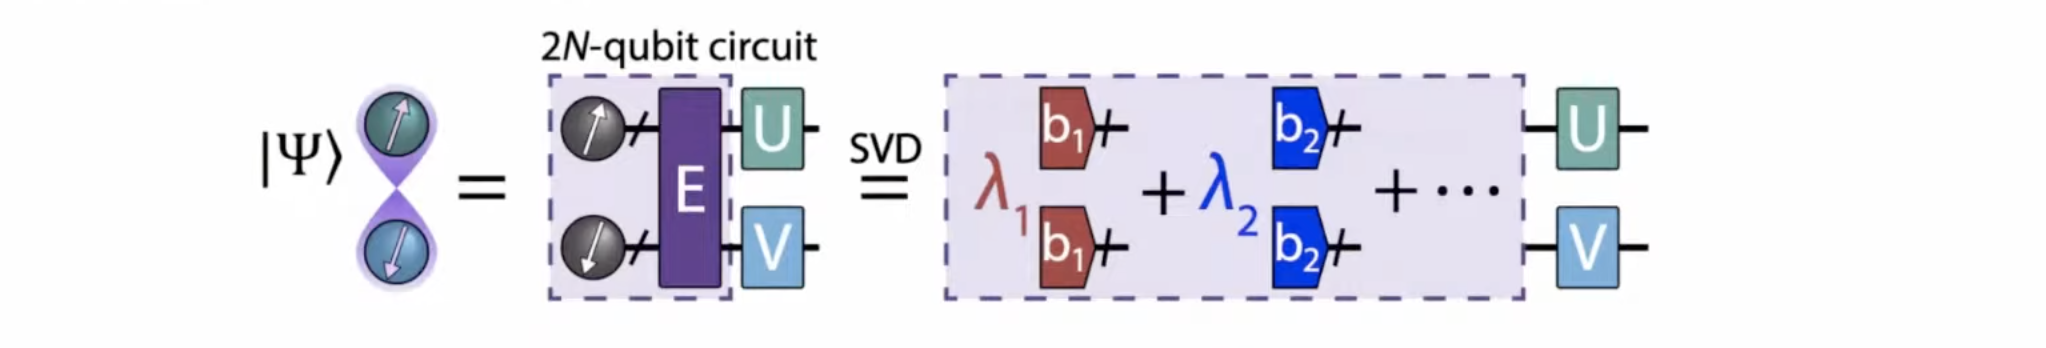

## Demo

In [ ]:
%load_ext autoreload
%autoreload 2

In [11]:
import numpy as np

from qiskit import QuantumCircuit, BasicAer
from qiskit.circuit.library import RealAmplitudes
from qiskit.opflow import PauliSumOp

In [57]:
observable = PauliSumOp.from_list(
    [
        ("IIXZ", -1.052373245772859),
        ("IZXZ", 0.39793742484318045),
        ("ZIZZ", -0.39793742484318045),
        ("ZZXZ", -0.01128010425623538),
        ("XXZZ", 0.18093119978423156),
    ]
)

U = RealAmplitudes(num_qubits=2, reps=2)

bitsrings = [[0, 1], [1, 0]]
schmidts = [1/np.sqrt(2**2), 1/np.sqrt(2**2)]

print("Schmidts:", schmidts)
print("Observable:")
print(observable)
print("U:")
U.decompose().draw()

Schmidts: [0.5, 0.5]
Observable:
-1.052373245772859 * IIXZ
+ 0.39793742484318045 * IZXZ
- 0.39793742484318045 * ZIZZ
- 0.01128010425623538 * ZZXZ
+ 0.18093119978423156 * XXZZ
U:


┌──────────┐     ┌──────────┐     ┌──────────┐
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├──■──┤ Ry(θ[4]) ├
     ├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├┤ X ├┤ Ry(θ[5]) ├
     └──────────┘└───┘└──────────┘└───┘└──────────┘

In [58]:
from qiskit.evaluators import EntanglementForgingExpectationValue

In [59]:
expval = EntanglementForgingExpectationValue(U, observable,
                                             bitstrings=bitsrings,
                                             schmidts=schmidts,
                                             backend=BasicAer.get_backend("qasm_simulator"))

expectation = expval.evaluate([0, 1, 1, 2, 3, 5], shots=1000).value
print("EF exp value: {}".format(expectation))

EF exp value: 0.01300421312751825
